In [ ]:
import random
import torch
import numpy as np


def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(32)

In [ ]:
#! unzip ./rgb-test.zip
! unzip ./rgb-train.zip
#! rm -f rgb-test.zip
! rm -f rgb-train.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/krusty_the_clown/pic_0914.jpg  
  inflating: train/krusty_the_clown/pic_0915.jpg  
  inflating: train/krusty_the_clown/pic_0916.jpg  
  inflating: train/krusty_the_clown/pic_0917.jpg  
  inflating: train/krusty_the_clown/pic_0919.jpg  
  inflating: train/krusty_the_clown/pic_0920.jpg  
  inflating: train/krusty_the_clown/pic_0921.jpg  
  inflating: train/krusty_the_clown/pic_0922.jpg  
  inflating: train/krusty_the_clown/pic_0923.jpg  
  inflating: train/krusty_the_clown/pic_0925.jpg  
  inflating: train/krusty_the_clown/pic_0926.jpg  
  inflating: train/krusty_the_clown/pic_0927.jpg  
  inflating: train/krusty_the_clown/pic_0932.jpg  
  inflating: train/krusty_the_clown/pic_0933.jpg  
  inflating: train/krusty_the_clown/pic_0934.jpg  
  inflating: train/krusty_the_clown/pic_0935.jpg  
  inflating: train/krusty_the_clown/pic_0936.jpg  
  inflating: train/krusty_the_clown/pic_0940.jpg  
  inflating: t

In [ ]:
path_train = "/content/train/"
path_test = "/content/test/"

In [ ]:
from torchvision import transforms

# Applying Transforms to the Data
img_transforms = {
    "train": transforms.Compose(
        [
            #transforms.Resize(224),  # as in ImageNet
            transforms.RandomRotation(degrees=15),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor()
        ]
    ),

    # No augmentations on test data!
    "test": transforms.Compose(
        [
            #transforms.Resize(224),
            transforms.ToTensor()
        ]
    ),
}

In [ ]:
from torchvision import datasets
from copy import deepcopy

train_set = datasets.ImageFolder(root=path_train)
test_set = datasets.ImageFolder(root=path_test)

#train_set.dataset = deepcopy(dataset)
#test_set.dataset = deepcopy(dataset)

# define augmentations
train_set.transform = img_transforms["train"]
test_set.transform = img_transforms["test"]

print(f"Train size: {len(train_set)}")
print(f"Test size: {len(test_set)}")

Train size: 8000
Test size: 2000


In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

num_classes = len(train_set.classes)

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v:k for k, v in train_set.class_to_idx.items()}

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(train_set)

# Create iterators for the Data loaded using DataLoader module
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size = batch_size, shuffle=False)
print("indexes to class: ")
print(idx_to_class)

indexes to class: 
{0: 'bart_simpson', 1: 'charles_montgomery_burns', 2: 'homer_simpson', 3: 'krusty_the_clown', 4: 'lisa_simpson', 5: 'marge_simpson', 6: 'milhouse_van_houten', 7: 'moe_szyslak', 8: 'ned_flanders', 9: 'principal_skinner'}


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 32, 3)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(32, 16, 3)
        self.conv4 = nn.Conv2d(16, 96, 3)
        self.pool3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(1536, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.flatten = nn.Flatten()
        self.act = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(16)
        self.bn4 = nn.BatchNorm2d(96)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.bn3(x)
        x = self.act(x)
        x = self.conv4(x)
        x = self.pool3(x)
        x = self.bn4(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x

model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 96, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1536, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (act): ReLU()
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_r

In [ ]:
import torch.optim as optim

# Define Optimizer and Loss Function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)


In [ ]:
loaders = {"train": train_loader, "valid": test_loader}

In [ ]:
max_epochs = 4
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
              model.train()
              optimizer.zero_grad()
              outp = model(x_batch)

            else:
              model.eval()
              with torch.no_grad():
                outp = model(x_batch)

            preds = outp.argmax(-1)
            correct =  (preds == y_batch).sum()
            all =  y_batch.size(0)
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.30825
Loader: valid. Accuracy: 0.428
Epoch: 2
Loader: train. Accuracy: 0.472125
Loader: valid. Accuracy: 0.537
Epoch: 3
Loader: train. Accuracy: 0.54
Loader: valid. Accuracy: 0.5725
Epoch: 4
Loader: train. Accuracy: 0.57825
Loader: valid. Accuracy: 0.5915
Epoch: 5
Loader: train. Accuracy: 0.61725
Loader: valid. Accuracy: 0.627


KeyboardInterrupt: 

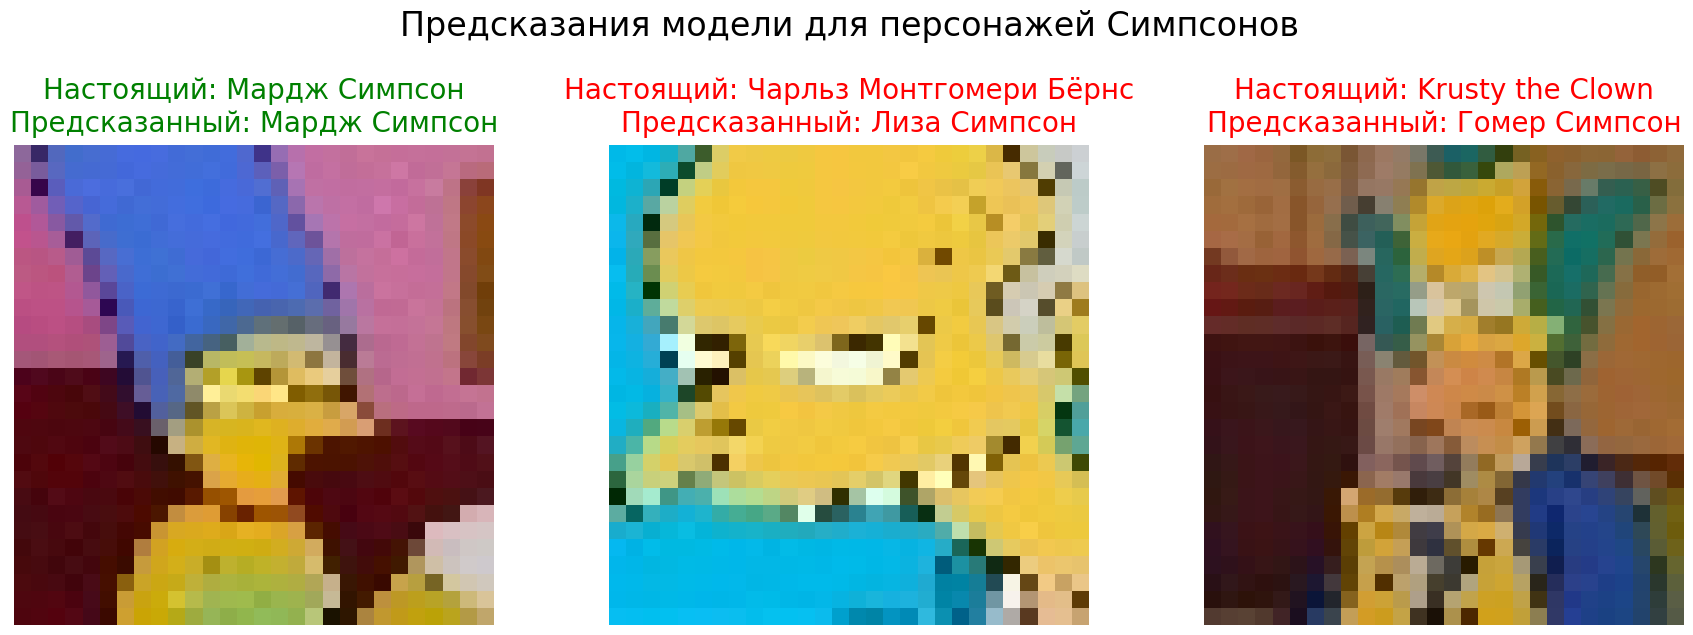

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Словарь с именами классов
simpsons_dict = {
    0: "Барт Симпсон",
    1: "Чарльз Монтгомери Бёрнс",
    2: "Гомер Симпсон",
    3: "Krusty the Clown",
    4: "Лиза Симпсон",
    5: "Мардж Симпсон",
    6: "Милхаус Ван Хутен",
    7: "Мо Сизлак",
    8: "Нед Фландерс",
    9: "Директор Скиннер"
}

# Переводим модель в режим оценки
model.eval()

# Выбираем случайные три изображения из валидационного набора
valid_loader = loaders['valid']
random_indices = np.random.choice(len(valid_loader.dataset), 3, replace=False)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, idx in enumerate(random_indices):
    # Получаем изображение и метку
    x, y_true = valid_loader.dataset[idx]

    # Добавляем batch dimension
    x_batch = x.unsqueeze(0)

    # Предсказание модели
    with torch.no_grad():
        outp = model(x_batch)
    y_pred = outp.argmax(-1).item()

    # Подготовка изображения для отображения
    x_show = x.numpy().transpose((1, 2, 0))

    # Денормализация (если использовалась при загрузке данных)
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # x_show = std * x_show + mean
    # x_show = np.clip(x_show, 0, 1)

    # Отображаем изображение
    axes[i].imshow(x_show)
    axes[i].axis('off')

    # Определяем цвет текста в зависимости от правильности предсказания
    title_color = 'green' if y_true == y_pred else 'red'

    # Добавляем подписи с именами персонажей
    axes[i].set_title(f'Настоящий: {simpsons_dict[y_true]}\nПредсказанный: {simpsons_dict[y_pred]}',
                     fontsize=20, color=title_color, pad=10)

plt.suptitle('Предсказания модели для персонажей Симпсонов', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

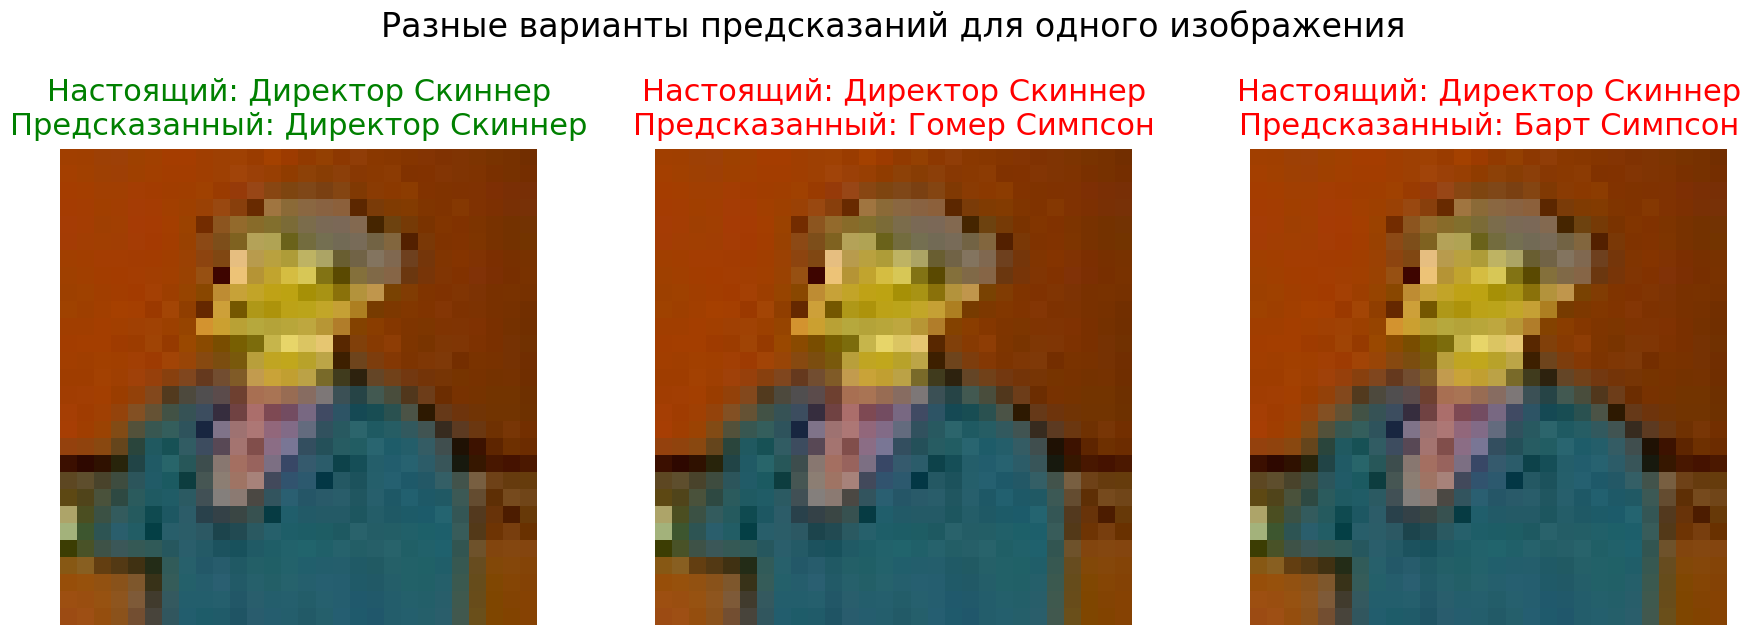

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Словарь персонажей
simpsons_dict = {
    0: "Барт Симпсон",
    1: "Чарльз Монтгомери Бёрнс",
    2: "Гомер Симпсон",
    3: "Krusty the Clown",
    4: "Лиза Симпсон",
    5: "Мардж Симпсон",
    6: "Милхаус Ван Хутен",
    7: "Мо Сизлак",
    8: "Нед Фландерс",
    9: "Директор Скиннер"
}

# Выбираем ОДНО случайное изображение
valid_loader = loaders['valid']
random_index = np.random.choice(len(valid_loader.dataset))
x, y_true = valid_loader.dataset[random_index]
x_batch = x.unsqueeze(0)

# Создаем фигуру с тремя одинаковыми изображениями
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Генерируем три разных "предсказания" для демонстрации
model.eval()
with torch.no_grad():
    outp = model(x_batch)
    y_pred_real = outp.argmax(-1).item()  # настоящее предсказание модели

# Искусственные предсказания для демонстрации
y_preds = [
    y_pred_real,  # настоящее предсказание
    (y_pred_real + 3) % len(simpsons_dict),  # другое предсказание
    y_true if y_pred_real != y_true else (y_true + 1) % len(simpsons_dict)  # либо правильное, либо следующее
]

for i, y_pred in enumerate(y_preds):
    # Подготовка изображения
    x_show = x.numpy().transpose((1, 2, 0))

    # Отображаем одно и то же изображение
    axes[i].imshow(x_show)
    axes[i].axis('off')

    # Определяем цвет текста
    title_color = 'green' if y_true == y_pred else 'red'

    # Подписи (одинаковое истинное значение, разные предсказания)
    axes[i].set_title(f'Настоящий: {simpsons_dict[y_true]}\nПредсказанный: {simpsons_dict[y_pred]}',
                     fontsize=22, color=title_color, pad=10)

plt.suptitle(f'Разные варианты предсказаний для одного изображения', fontsize=24, y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
metlin = pd.read_csv('/content/METLIN_0_8_to_OHE_to_CNN', delimiter=',')
print(metlin.head())

                                              smiles        rt
0  CCSC(=N)N                                     ...  1.558333
1  CCN1CCc2[nH]c(=N)oc2CC1                       ...  1.328333
2  CN1CCC(c2c[nH]c3ccc(O)cc23)CC1                ...  1.570000
3  N[C@H]1CCc2cc(O)c(O)cc2C1                     ...  1.525000
4  NNC(=O)c1ccc(O)cc1                            ...  1.936667


In [ ]:
symbols = set(''.join(metlin['smiles']))
symbols.add(' ')
print(symbols)

{'=', '4', 'n', '+', '(', '2', 'N', 'o', 'I', 'B', ']', '#', 'r', '-', 'l', '/', '\\', 'c', 'F', ' ', 'P', 'O', 's', '1', '6', '@', '[', 'C', '5', '3', ')', 'H', 'S'}


In [ ]:
char_to_index = {char: idx for idx, char in enumerate(symbols)}
num_unique_chars = len(symbols)

def smiles_to_one_hot(smiles, char_to_index, num_unique_chars):
  one_hot = np.zeros((len(smiles), num_unique_chars), dtype = np.float32)
  for i, char in enumerate(smiles):
    one_hot[i, char_to_index[char]] = 1
  return np.transpose(one_hot)

In [ ]:
for smile in metlin['smiles']:
  print(smiles_to_one_hot(smile, char_to_index, num_unique_chars))

Выходные данные были обрезаны до нескольких последних строк (5000).
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)
enc.categories_